## Bibliotecas

In [4]:
import subprocess
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

## Estimativa da memória

- O ambiente utilizado para essa execução é um WSL com Ubunto como OS
- No momento da execução, há MemFree é a quantidade de memória livre, do total (MemTotal) do sistema

O Valor da memória livre varia dependendo dos programas em execução

In [6]:
with open("/proc/meminfo", 'r') as memory_status:
    lines = memory_status.readlines()
    memtotal = int(lines[0].split('kB')[0].split(':')[1])
    memfree = int(lines[1].split('kB')[0].split(':')[1])
    print(lines[0])
    print(lines[1])
    

MemTotal:       16469120 kB

MemFree:        11689484 kB



O consumo de memória dos programa se dá, manjoritariamente, pela alocação da matriz, ou seja, complexidade de espaço $O(n^2)$. Dessa forma, assumindo que os programas só utilizarão a RAM disponível, temos que:

$$
    n_{max}^2  \cdot size(e) \leq mfree \\
   
$$
$$
 n_{max} \leq \sqrt{\frac{mfree}{size(e)}}
$$

Sendo $n_{max}$ o tamanho máximo da dimensão da matriz, $size(e)$ o número de bytes necessários para armazenar um elemento da matriz e  $mfree$ a quantidade de memória livre em bytes.


Nesse sentindo, supondo que a memória impressa anteriormente estará livre e disponível para a alocação pelo programador, no momento da execução do programa, teríamos os seguintes valores de $n_{max}$ para Fortran utilizando tipo $Real$ ( $size(e) = 4$) e para C utilizando tipo $float$ ($size(e) = 4$).


In [7]:
n_max = round(np.sqrt(memfree*1000/4))
n_max

54059

- Vamos testar o programas para várias dimensões $n$, aumentando-as de 1000 unidades a cada passo até chegar no máximo estimado. Isso vai nos dar 54 pontos para a curva.

In [8]:
n_max/1000

54.059

## Estimativa de Tempo para cada N

### Para o programa em Fortran
<hr/>

- Sem inverter o loop

In [1]:
csv_file = 'results/fortran_lines_first.csv'
with open(csv_file, 'a') as f:
    f.write('n,tempo\n')

In [9]:
for n in range(1000, n_max, 1000):
    try:
        out = subprocess.check_output(["./src/program1.out", f'{n}', '0'])
    except subprocess.CalledProcessError as e:
        print(e.output)
        break
    else: 
        with open(csv_file, 'a') as f:
            f.write(f'{n}, {float(out)}\n')

- Invertendo o loop

In [10]:
csv_file = 'results/fortran_columns_first.csv'
with open(csv_file, 'a') as f:
    f.write('n,tempo\n')

In [11]:
for n in range(1000, n_max, 1000):
    try:
        out = subprocess.check_output(["./src/program1.out", f'{n}', '1'])
    except subprocess.CalledProcessError as e:
        print(e.output)
        break
    else: 
        with open(csv_file, 'a') as f:
            f.write(f'{n}, {float(out)}\n')

### Para o programa em C
<hr/>

- Sem inverter o loop

In [13]:
csv_file = 'results/c_lines_first.csv'
with open(csv_file, 'a') as f:
    f.write('n,tempo\n')

In [14]:
for n in range(1000, n_max, 1000):
    try:
        out = subprocess.check_output(["./src/program2.out", f'{n}', '0'])
    except subprocess.CalledProcessError as e:
        print(e.output)
        break
    else: 
        with open(csv_file, 'a') as f:
            f.write(f'{n}, {float(out)}\n')

- Invertendo o loop

In [15]:
csv_file = 'results/c_columns_first.csv'
with open(csv_file, 'a') as f:
    f.write('n,tempo\n')

In [16]:
for n in range(1000, n_max, 1000):
    try:
        out = subprocess.check_output(["./src/program2.out", f'{n}', '1'])
    except subprocess.CalledProcessError as e:
        print(e.output)
        break
    else: 
        with open(csv_file, 'a') as f:
            f.write(f'{n}, {float(out)}\n')

## Análise


In [25]:
fortran_l = pd.read_csv('results/fortran_lines_first.csv', dtype={'tempo':float})
fortran_c = pd.read_csv('results/fortran_columns_first.csv', dtype={'tempo':float})
c_l = pd.read_csv('results/c_lines_first.csv', dtype={'tempo':float})
c_c = pd.read_csv('results/c_columns_first.csv', dtype={'tempo':float})

In [26]:
fortran_l_time = np.array(fortran_l['tempo'].to_list())
fortran_c_time = np.array(fortran_c['tempo'].to_list())
c_l_time = np.array(c_l['tempo'].to_list())
c_c_time = np.array(c_c['tempo'].to_list())
n = np.array(c_c['n'].to_list())

### Relação com $O(N^2)$
- Vamos verificar se as curvas formadas são quadráticas, ou seja, correspondem com a complexidade de tempo $O(n^2)$

In [27]:
def q(x, a, b):
    return a*x+b*x*x


(a_fortran_l,b_fortran_l), pcov = curve_fit(q, n, fortran_l_time, p0=[0.05,0.05])
(a_fortran_c,b_fortran_c), pcov = curve_fit(q, n, fortran_c_time, p0=[0.05,0.05])
(a_c_l,b_c_l), pcov = curve_fit(q, n, c_l_time, p0=[0.05,0.05])
(a_c_c,b_c_c), pcov = curve_fit(q, n, c_c_time, p0=[0.05,0.05])

In [28]:
ymodel_fortran_l = q(n, a_fortran_l, b_fortran_l) 
ymodel_fortran_c = q(n, a_fortran_c, b_fortran_c) 
ymodel_c_c = q(n, a_c_c, b_c_c) 
ymodel_c_l = q(n, a_c_l, b_c_l) 

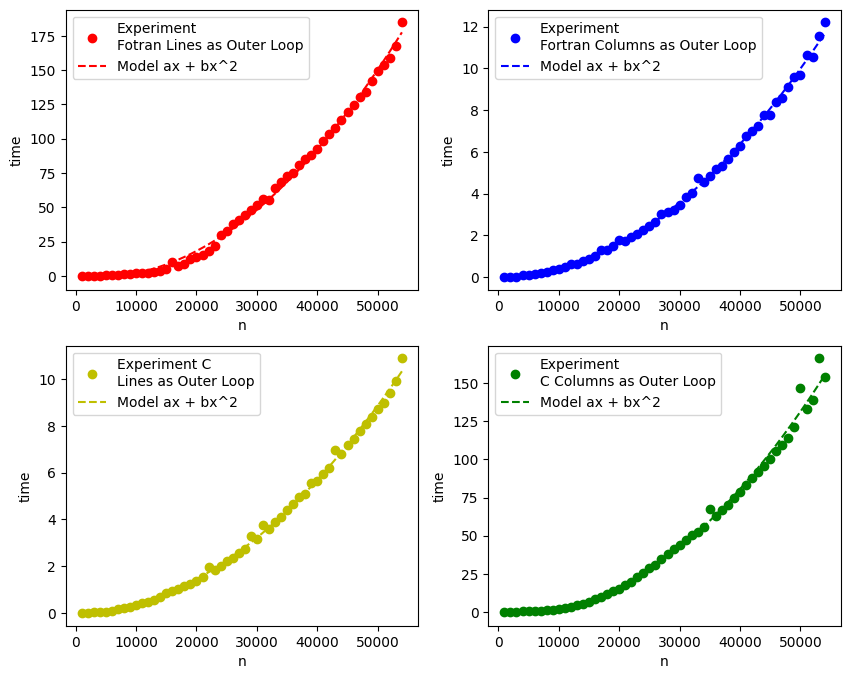

In [57]:
fig, ax1 = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(10)

ax1[0, 0].plot(n, fortran_l_time, "ro", label="Experiment\nFotran Lines as Outer Loop")
ax1[0, 0].plot(n, ymodel_fortran_l, "r--", label=f"Model ax + bx^2")
ax1[0, 0].set_xlabel('n')
ax1[0, 0].set_ylabel('time')

ax1[0, 0].legend()

ax1[0, 1].plot(n, fortran_c_time, "bo", label="Experiment\nFortran Columns as Outer Loop")
ax1[0, 1].plot(n, ymodel_fortran_c, "b--", label=f"Model ax + bx^2")
ax1[0, 1].set_xlabel('n')
ax1[0, 1].set_ylabel('time')
ax1[0, 1].legend()

ax1[1, 0].plot(n, c_l_time, "yo", label="Experiment C\nLines as Outer Loop")
ax1[1, 0].plot(n, ymodel_c_l, "y--", label=f"Model ax + bx^2")
ax1[1, 0].set_xlabel('n')
ax1[1, 0].set_ylabel('time')
ax1[1, 0].legend()

ax1[1, 1].plot(n, c_c_time, "go", label="Experiment\nC Columns as Outer Loop")
ax1[1, 1].plot(n, ymodel_c_c, "g--", label=f"Model ax + bx^2")
ax1[1, 1].set_xlabel('n')
ax1[1, 1].set_ylabel('time')
ax1[1, 1].legend()
plt.show()

### Comparação das diferentes ordens de loop

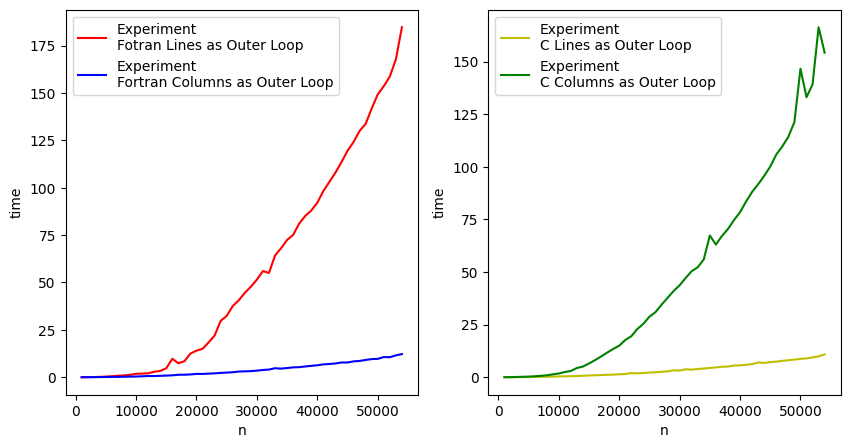

In [58]:
fig, ax1 = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(10)

ax1[0].plot(n, fortran_l_time, "r", label="Experiment\nFotran Lines as Outer Loop")
ax1[0].plot(n, fortran_c_time, "b", label="Experiment\nFortran Columns as Outer Loop")
ax1[0].set_xlabel('n')
ax1[0].set_ylabel('time')
ax1[0].legend()


ax1[1].plot(n, c_l_time, "y", label="Experiment\nC Lines as Outer Loop")
ax1[1].plot(n, c_c_time, "g", label="Experiment\nC Columns as Outer Loop")
ax1[1].set_xlabel('n')
ax1[1].set_ylabel('time')
ax1[1].legend()
plt.show()

### Testes antigos

In [46]:
fortran_old = pd.read_csv('results/fortran_cols_first_old_test.csv', dtype={'tempo':float})

In [47]:
fortran_old.tail(10)

,n,tempo
107,64800,55.062500
108,65400,53.640625
109,66000,55.593750
110,66600,55.750000
111,67200,59.875000
112,67800,62.687500
113,68400,66.187500
114,69000,68.703125
115,69600,66.937500
116,70200,72.031250
